# Download library

In [ ]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-8q102l8o
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-8q102l8o
  Resolved https://github.com/huggingface/accelerate to commit 777334a803e7e07e00a52c08a096cc40abc00255
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=247979 sha256=0b3cc775a8d68d16ffcd6be6c7aeaec3e13e91713e48c4ea9460decd3e6445a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-73oop4op/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [ ]:
# !pip install huggingface_hub

# Load data and pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [ ]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/yahoo_QA/train.csv",names=['class', 'title', 'content', 'answer'])


In [ ]:
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'}

In [ ]:
labels=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference',
        'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music',
        'Family & Relationships', 'Politics & Government']

In [ ]:
df['label'] = df['class'].map(categories)

In [ ]:
df = df.drop('class', axis=1)

In [ ]:
label_dict = dict(zip(labels, range(0,len(labels))))
df['index']=df['label'].apply(labels.index)

In [ ]:
df.groupby(['label']).size()

label
Business & Finance        140000
Computers & Internet      140000
Education & Reference     140000
Entertainment & Music     140000
Family & Relationships    140000
Health                    140000
Politics & Government     140000
Science & Mathematics     140000
Society & Culture         140000
Sports                    140000
dtype: int64

In [ ]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 500)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),500)
health_idx=random.sample(list(df.query('label=="Health"').index),500)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),500)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),500)

# Use indices to select data
df= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

# Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['title'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Train

In [ ]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 5)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),5)
health_idx=random.sample(list(df.query('label=="Health"').index),5)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),5)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),5)

# Use indices to select data
train= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [ ]:
test=df.drop(index=(index_list))
valid, test = train_test_split(test, test_size=0.8)

In [ ]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define parameters
EPOCHS = 20

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 2.3730993270874023 accuracy 0.12


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 2.217567228501843 accuracy 3.36

Epoch 2/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 2.186068058013916 accuracy 0.2


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 2.089333518858879 accuracy 3.36

Epoch 3/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.9598940014839172 accuracy 0.32


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.9768720788340415 accuracy 3.36

Epoch 4/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.9413959980010986 accuracy 0.24


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.853835598114998 accuracy 3.84

Epoch 5/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.7245460748672485 accuracy 0.44


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.781152102255052 accuracy 4.92

Epoch 6/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.4664196968078613 accuracy 0.68


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.7431644316642516 accuracy 6.68

Epoch 7/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.3718910217285156 accuracy 0.76


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.717747953630263 accuracy 6.6000000000000005

Epoch 8/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.2753267288208008 accuracy 0.8


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6460725338228288 accuracy 6.5200000000000005

Epoch 9/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.1522986888885498 accuracy 0.76


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6236546962491927 accuracy 7.72

Epoch 10/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.8259254395961761 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6165023542219592 accuracy 7.4

Epoch 11/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.849853128194809 accuracy 0.96


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5961060562441427 accuracy 7.68

Epoch 12/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.6712895333766937 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5742107898958269 accuracy 8.36

Epoch 13/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.6088267862796783 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5692364669615222 accuracy 8.4

Epoch 14/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.5901312828063965 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.588553793968693 accuracy 7.8

Epoch 15/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.5039997398853302 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.585688506403277 accuracy 7.92

Epoch 16/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.4613082855939865 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.587659308987279 accuracy 8.0

Epoch 17/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.4125365912914276 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.595094073203302 accuracy 7.8

Epoch 18/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.3762463927268982 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.600898008192739 accuracy 7.76

Epoch 19/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.33537429571151733 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6019827165911276 accuracy 7.88

Epoch 20/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.346555657684803 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6014857330629904 accuracy 7.88



In [ ]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.38384781767939247

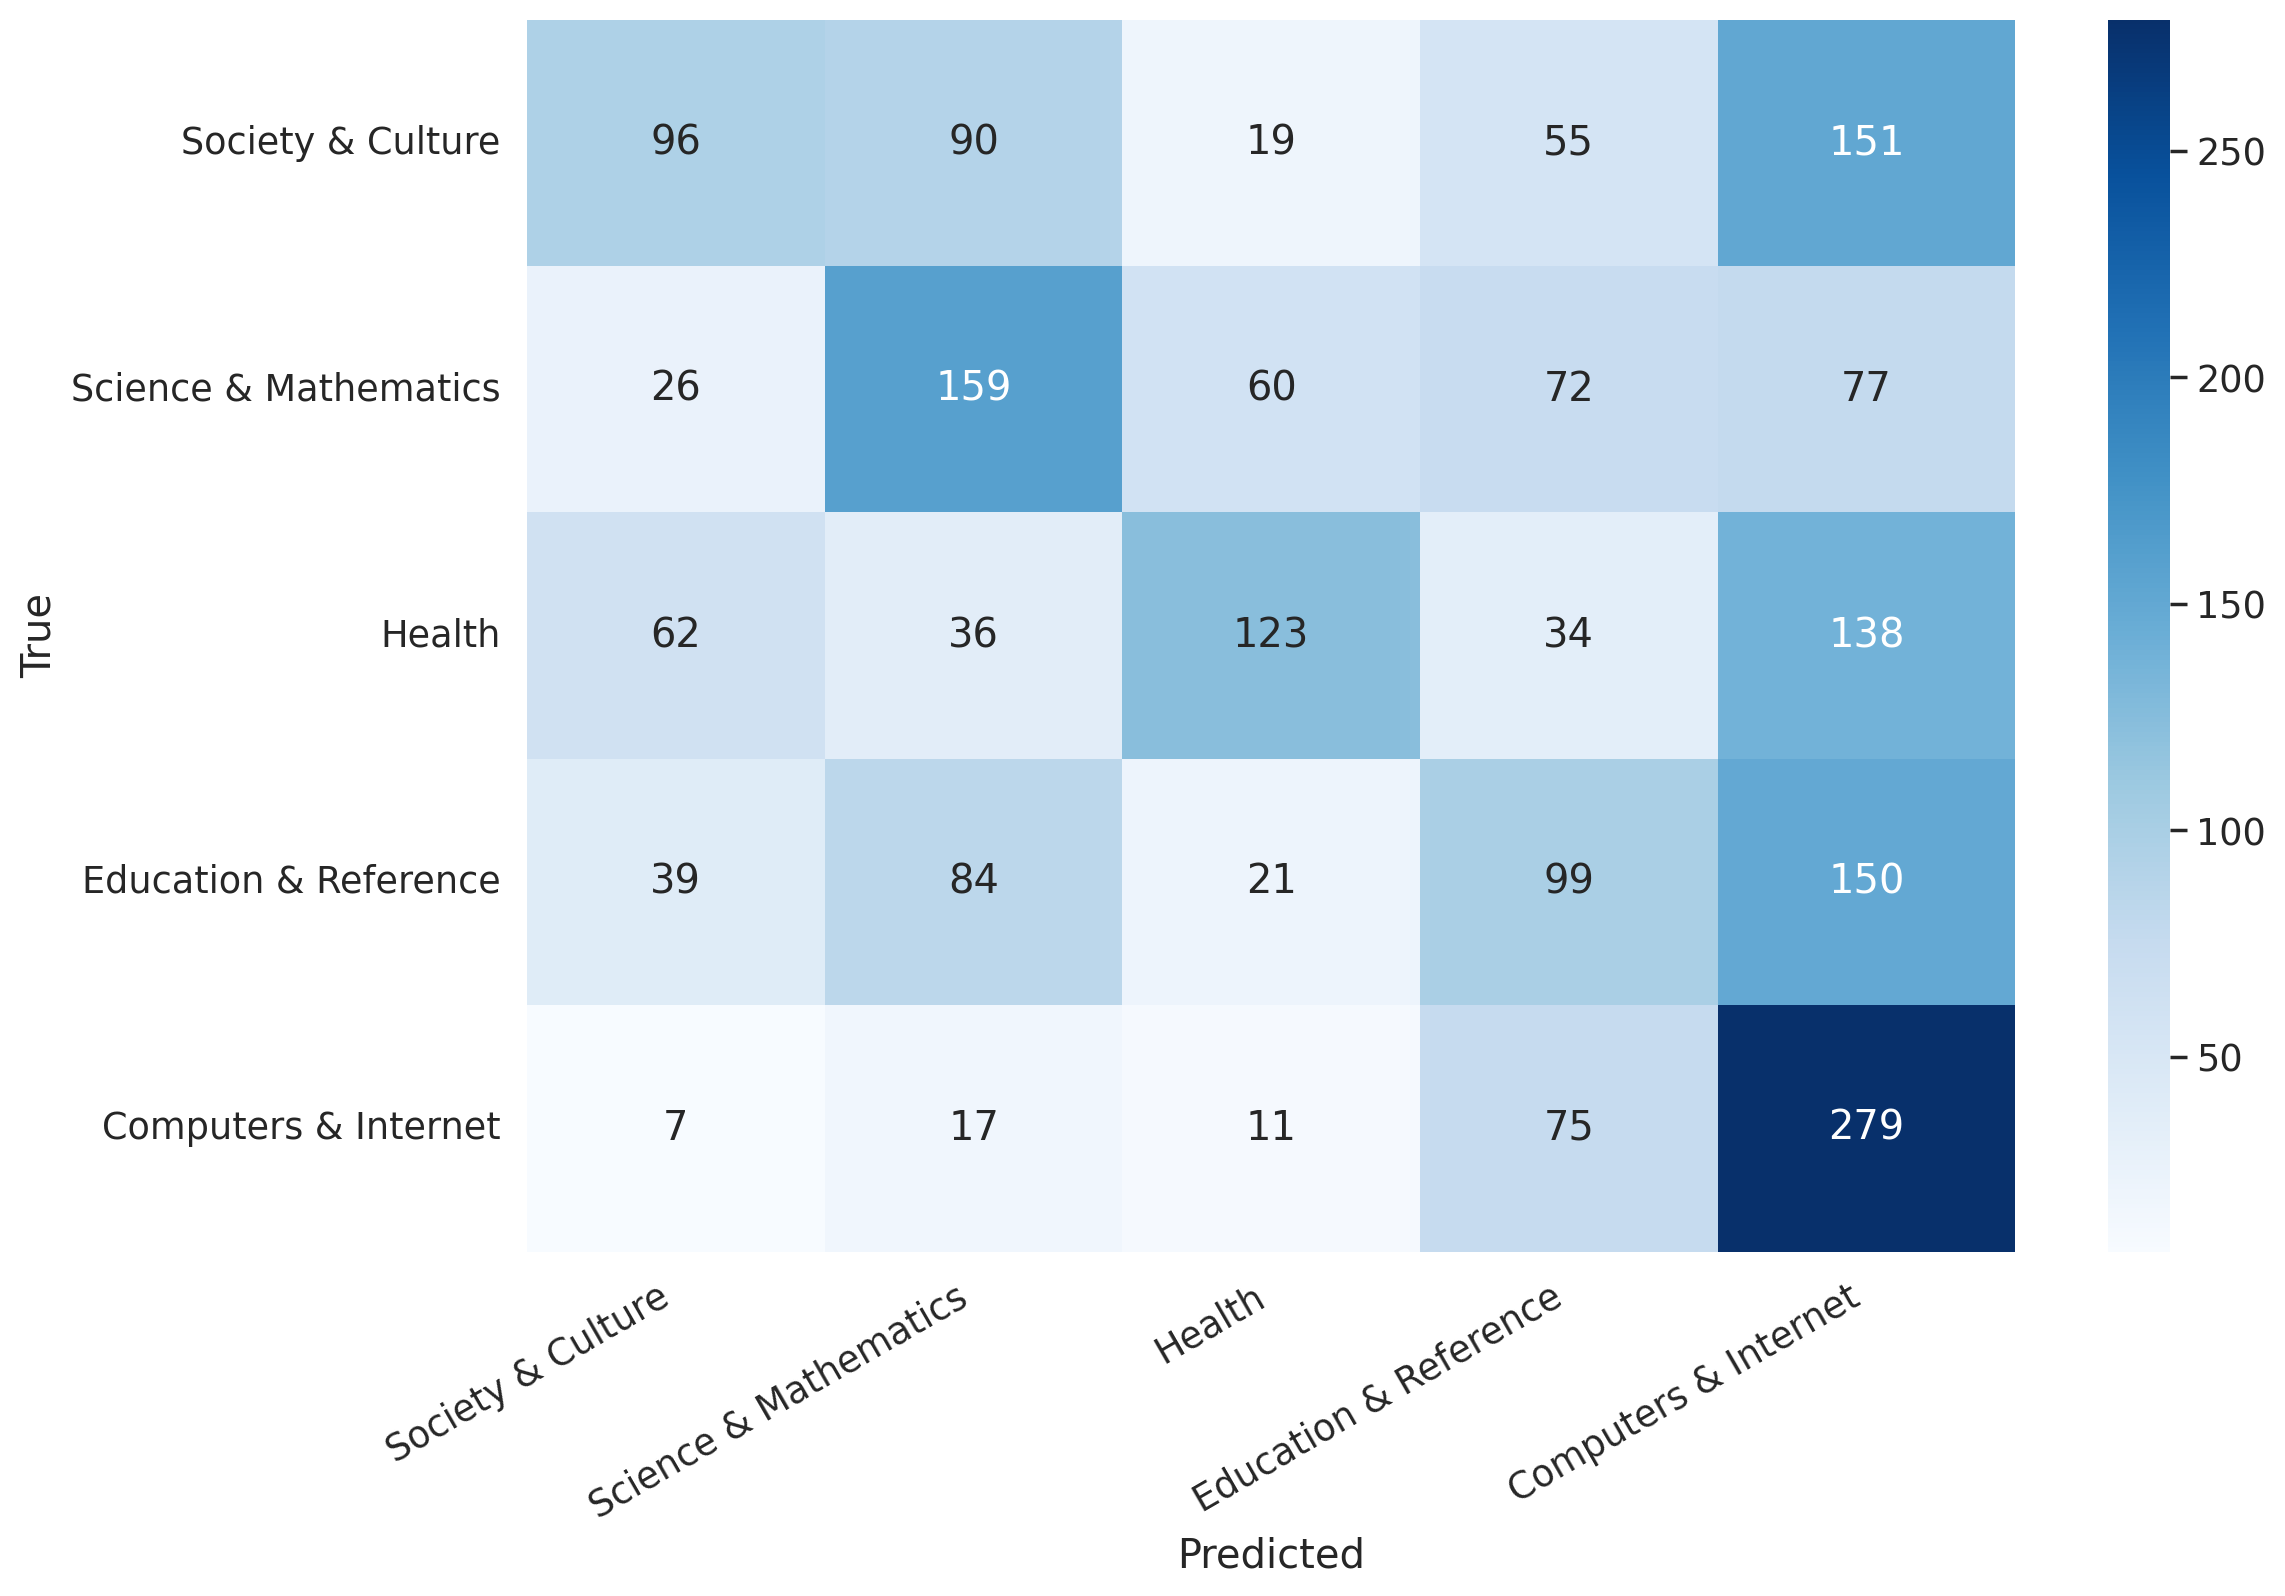

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.42      0.23      0.30       411
Science & Mathematics       0.41      0.40      0.41       394
               Health       0.53      0.31      0.39       393
Education & Reference       0.30      0.25      0.27       393
 Computers & Internet       0.35      0.72      0.47       389

             accuracy                           0.38      1980
            macro avg       0.40      0.38      0.37      1980
         weighted avg       0.40      0.38      0.37      1980

